# <center>INDIA ACADEMIA CONNECT AL HACKATHON 2021</center>

## Table of Contents

1. [Hackathon Description](#section1)<br>
2. [Problem Statement](#section2)<br>
3. [Installing & Importing Libraries](#section3)<br>
4. [Data Acquisition & Description](#section4)<br>
5. [Data Preprocessing](#section5)<br>
6. [Feature Selection](#section6)<br>
7. [Model Building](#section7)<br>  
8. [Plotting results](#section8)<br>
9. [Visualizing Prediction](#section9)<br>
10. [Creating a JSON file](#section10)<br> 

# 1. Hackathon Description 

Artificial intelligence will be an enormous part of the future workforce. It’s expected to generate 2 million net job gains versus losses by 2025. India Academia Connect AI Hackathon will help the participants from leading research institutions with the opportunity to learn and implement the latest AI technology, preparing them for a future AI-powered economy, with a large research and developer base.This Hackathon will be hosted online with all times Indian Standard Time (IST). All communication will be done through Zoom, Slack and email.Submissions are evaluated on Accuracy Score between the predicted and the actual labels on the test dataset.

# 2. Problem Statement

During the event, participants will be working on a problem of Image classification. The input dataset will consist of images containing Hindi characters. The challenge is to identify the presence of a character in images using Convolutional Neural Networks.

The dataset will contain the following:


*   Train Dataset: Consists of sample reference sets which can be used by
participants to train the Convolution Neural Network. The participants are recommended to use their own training dataset if required.
*  Test Dataset: The test dataset will contain the images to be classified and results to be submitted in the form of a JSON file. More details on the JSON format and a sample provided as part of the dataset. 

# 3. Installing and Importing the Libraries

In [1]:
import os,random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import ntpath


In [2]:
import keras,os
import tensorflow as tf
from keras.models import Sequential # Gets our neural network as sequential network
from keras.layers import Conv2D # Images are basically 2D
from keras.layers import MaxPool2D # Average Pooling, Sum Pooling and Max Pooling is there. we use Max pooling
from keras.layers import Flatten # It is process of converting all 2D array to continious linear vector
from keras.layers import Dense # Full connection of this neural network is performed using dense
from keras.preprocessing.image import ImageDataGenerator # It helps rescale, flip, rotate etc
import numpy as np

In [3]:
# Import VGG16 Pretrained model
# Instantiate convolutional base
from keras.applications.vgg16 import VGG16
tf.keras.applications.VGG16
from keras import layers
from keras import optimizers

#### Split of test folder is done separatly using below code ####

os.chdir('..') 

if os.path.isdir('test/background') is False: 

   os.makedirs('test/background')
   
   os.makedirs('test/hi')



     for c in  random.sample(glob.glob('background*'), 50):

         shutil.move(c, 'test/background')
  
   for c in random.sample(glob.glob('hi*'), 48 ):
   
         shutil.move(c, 'test/hi')

# Setup path for the images

In [4]:

base_dir = r'C:\Users\Jigna.thacker\Downloads\AI-Hackaton'
train_dir = os.path.join(base_dir, 'training')
test_dir = os.path.join(base_dir, 'test')
train_bg_dir = os.path.join(train_dir, 'background')

train_hi_dir = os.path.join(train_dir, 'hi')
test_hi_dir = os.path.join(test_dir, 'hi')
test_background_dir = os.path.join(test_dir, 'background')

In [5]:
file_count = sum(len(files) for _, _, files in os.walk(train_bg_dir))
print(file_count)

4450


In [6]:
file_count = sum(len(files) for _, _, files in os.walk(train_hi_dir))
print(file_count)

1425


In [7]:
file_count = sum(len(files) for _, _, files in os.walk(test_dir))
print(file_count)

100


In [8]:
train_size, test_size = 5875,98

In [9]:
img_width, img_height=64,64

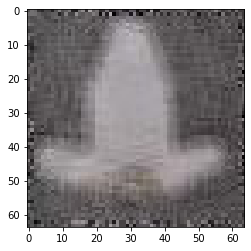

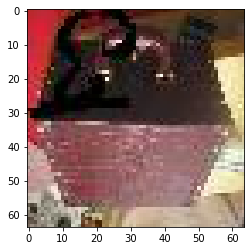

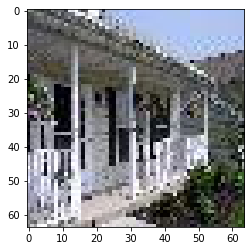

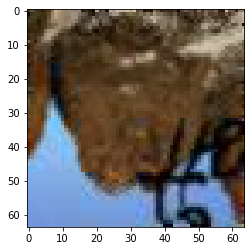

In [10]:
# Show pictures

def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_bg_dir)
    show_pictures(train_hi_dir)

In [11]:
vgg16covbase= VGG16(weights='imagenet', # pretraining on imagenet
                  include_top=False, # whether to include the 3 fully-connected layers at the top of the network.
                  input_shape=(64, 64, 3))  # 3 = number of channels in RGB pictures
# The entire layers are present inside this.The feature extractor is inbuilt

In [12]:
vgg16covbase.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [13]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 2, 2, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(64,64),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg16covbase.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size

test_features, test_labels = extract_features(test_dir, test_size)

Found 5875 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [14]:
from keras import models

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(2,2,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(2*2*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 524,801
Trainable params: 524,801
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [16]:
history = model.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=batch_size, 
                    validation_data=(test_features, test_labels))

Epoch 1/100
184/184 [==============================] - 1s 4ms/step - loss: 0.3891 - acc: 0.8315 - val_loss: 0.4700 - val_acc: 0.7755
Epoch 2/100
184/184 [==============================] - 1s 4ms/step - loss: 0.2748 - acc: 0.8889 - val_loss: 0.3903 - val_acc: 0.8265
Epoch 3/100
184/184 [==============================] - 1s 4ms/step - loss: 0.2422 - acc: 0.9038 - val_loss: 0.4813 - val_acc: 0.7959
Epoch 4/100
184/184 [==============================] - 1s 4ms/step - loss: 0.2044 - acc: 0.9202 - val_loss: 0.4042 - val_acc: 0.8367
Epoch 5/100
184/184 [==============================] - 1s 4ms/step - loss: 0.1838 - acc: 0.9258 - val_loss: 0.4208 - val_acc: 0.8571
Epoch 6/100
184/184 [==============================] - 1s 4ms/step - loss: 0.1602 - acc: 0.9389 - val_loss: 0.4037 - val_acc: 0.8673
Epoch 7/100
184/184 [==============================] - 1s 4ms/step - loss: 0.1397 - acc: 0.9469 - val_loss: 0.5355 - val_acc: 0.8163
Epoch 8/100
184/184 [==============================] - 1s 4ms/step - 

*Accuracy of the model after 100 epoches : 0.9927*

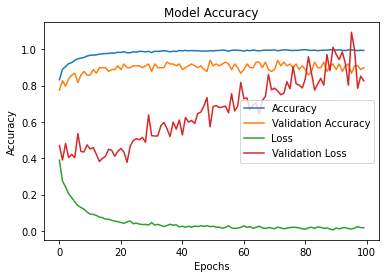

In [17]:
# Plot results
import matplotlib.pyplot as plt

plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epochs')
plt.legend(['Accuracy','Validation Accuracy','Loss', 'Validation Loss'])

In [18]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    datalist=[]
    for i in range(0,n_cases):
        path = random.choice([test_background_dir, test_hi_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = vgg16covbase.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        #plt.imshow(img_tensor)
        #plt.show()

        # Write prediction
        if prediction < 0.9:
            tup1=(ntpath.basename(img_path),'0')
            datalist.append(tup1)
            print(ntpath.basename(img_path),':0')
        else:
            tup2=(ntpath.basename(img_path),'1')
            datalist.append(tup2)
            print(ntpath.basename(img_path),':1')
    return(datalist) 

In [19]:

result=visualize_predictions(model, 98)

1.jpg :1
41.jpg :0
63.jpg :1
27.jpg :1
23.jpg :1
59.jpg :0
54.jpg :1
48.jpg :1
7.jpg :1
39.jpg :0
75.jpg :0
92.jpg :0
17.jpg :0
93.jpg :1
67.jpg :1
59.jpg :0
67.jpg :1
56.jpg :0
82.jpg :1
27.jpg :1
78.jpg :0
38.jpg :0
1.jpg :1
49.jpg :0
24.jpg :1
54.jpg :1
2.jpg :0
67.jpg :1
72.jpg :0
96.jpg :0
29.jpg :1
96.jpg :0
50.jpg :1
52.jpg :1
74.jpg :0
66.jpg :0
24.jpg :1
75.jpg :0
19.jpg :1
16.jpg :0
18.jpg :0
89.jpg :0
55.jpg :1
31.jpg :0
88.jpg :0
9.jpg :0
91.jpg :1
42.jpg :1
31.jpg :0
95.jpg :0
17.jpg :0
1.jpg :1
68.jpg :1
58.jpg :0
29.jpg :1
10.jpg :0
17.jpg :0
18.jpg :0
63.jpg :1
70.jpg :1
96.jpg :0
55.jpg :1
69.jpg :1
48.jpg :1
31.jpg :0
73.jpg :1
44.jpg :0
40.jpg :1
73.jpg :1
51.jpg :0
54.jpg :1
14.jpg :0
26.jpg :1
15.jpg :0
55.jpg :1
70.jpg :1
53.jpg :1
20.jpg :0
81.jpg :1
1.jpg :1
26.jpg :1
54.jpg :1
82.jpg :1
80.jpg :0
31.jpg :0
68.jpg :1
77.jpg :0
25.jpg :0
17.jpg :0
89.jpg :0
98.jpg :0
41.jpg :0
6.jpg :0
23.jpg :1
55.jpg :1
63.jpg :1
56.jpg :0
90.jpg :1


In [20]:
print(type(result))

<class 'list'>


In [21]:
result

[('1.jpg', '1'),
 ('41.jpg', '0'),
 ('63.jpg', '1'),
 ('27.jpg', '1'),
 ('23.jpg', '1'),
 ('59.jpg', '0'),
 ('54.jpg', '1'),
 ('48.jpg', '1'),
 ('7.jpg', '1'),
 ('39.jpg', '0'),
 ('75.jpg', '0'),
 ('92.jpg', '0'),
 ('17.jpg', '0'),
 ('93.jpg', '1'),
 ('67.jpg', '1'),
 ('59.jpg', '0'),
 ('67.jpg', '1'),
 ('56.jpg', '0'),
 ('82.jpg', '1'),
 ('27.jpg', '1'),
 ('78.jpg', '0'),
 ('38.jpg', '0'),
 ('1.jpg', '1'),
 ('49.jpg', '0'),
 ('24.jpg', '1'),
 ('54.jpg', '1'),
 ('2.jpg', '0'),
 ('67.jpg', '1'),
 ('72.jpg', '0'),
 ('96.jpg', '0'),
 ('29.jpg', '1'),
 ('96.jpg', '0'),
 ('50.jpg', '1'),
 ('52.jpg', '1'),
 ('74.jpg', '0'),
 ('66.jpg', '0'),
 ('24.jpg', '1'),
 ('75.jpg', '0'),
 ('19.jpg', '1'),
 ('16.jpg', '0'),
 ('18.jpg', '0'),
 ('89.jpg', '0'),
 ('55.jpg', '1'),
 ('31.jpg', '0'),
 ('88.jpg', '0'),
 ('9.jpg', '0'),
 ('91.jpg', '1'),
 ('42.jpg', '1'),
 ('31.jpg', '0'),
 ('95.jpg', '0'),
 ('17.jpg', '0'),
 ('1.jpg', '1'),
 ('68.jpg', '1'),
 ('58.jpg', '0'),
 ('29.jpg', '1'),
 ('10.jpg', '0')

*saving data in *.json format*

In [22]:
import json
import pandas as pd

In [23]:
df=pd.DataFrame(result)

In [24]:
df

,0,1
0,1.jpg,1
1,41.jpg,0
2,63.jpg,1
3,27.jpg,1
4,23.jpg,1
...,...,...
93,23.jpg,1
94,55.jpg,1
95,63.jpg,1
96,56.jpg,0


In [25]:
df2 = df.set_axis(['name','value'], axis=1, inplace=False)


In [26]:
df2

,name,value
0,1.jpg,1
1,41.jpg,0
2,63.jpg,1
3,27.jpg,1
4,23.jpg,1
...,...,...
93,23.jpg,1
94,55.jpg,1
95,63.jpg,1
96,56.jpg,0


In [27]:
df2.to_json('Team_Rock.json')

**THANK YOU**